In [8]:
import glob
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import emcee
from astropy import units as u
import seaborn as sns
from mpi4py import MPI
from schwimmbad import MPIPool
import sys
import time
import getdist
import IPython
from getdist import plots, MCSamples

In [5]:
def loadsqmat(filename):
    dat = np.loadtxt(f'{filename}')
    n = int(dat[0])
    mat = dat[1:].reshape(n, n)
    return mat

#Data
data = pd.read_csv('jla_likelihood_v6/jla_likelihood_v6/data/jla_lcparams.txt', sep='\s+') #Datos observacionales de https://arxiv.org/pdf/1401.4064
C_eta = sum([fits.getdata(mat) for mat in glob.glob('C*.fits')]) #Matriz para calcular C_eta
luvec = lumvec(data['3rdvar']) #Vector de \Delta{M_B}
eta = eta_matrix(data['x1'],data['color'],data['mb']) #Datos de SN
z = data['zcmb'] #Datos de redshift para cada supernova

#Función para calcular c_stat
def c_stat(n): #Número de SN
    #Datos de la matriz de covarianza
    c00 = loadsqmat('jla_v0_covmatrix.dat')
    c11 = loadsqmat('jla_va_covmatrix.dat')
    c22 = loadsqmat('jla_vb_covmatrix.dat')
    c01 = loadsqmat('jla_v0a_covmatrix.dat')
    c02 = loadsqmat('jla_v0b_covmatrix.dat')
    c12 = loadsqmat('jla_vab_covmatrix.dat')
    c = np.zeros((3 * n, 3 * n)) #Generamos un array de (2220,2220)
    #loop para crear la matriz iterando sobre todas las entradas de la matriz
    for i in range(n):
        for j in range(n):
            c[3 * i + 2, 3 * j + 2] = c00[i, j]
            c[3 * i + 1, 3 * j + 1] = c11[i, j]
            c[3 * i, 3 * j] = c22[i, j]
    
            c[3 * i + 2, 3 * j + 1] = c01[i, j]
            c[3 * i + 2, 3 * j] = c02[i, j]
            c[3 * i, 3 * j + 1] = c12[i, j]
    
            c[3 * j + 1, 3 * i + 2] = c01[i, j]
            c[3 * j, 3 * i + 2] = c02[i, j]
            c[3 * j + 1, 3 * i] = c12[i, j]

    return c
    
#ceta = np.load('ceta.npy')
ceta = c_stat(740)

#Función para calcular la matriz Cmu tomada de https://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html
def mu_cov(alpha, beta,Ceta):
    Cmu = np.zeros_like(Ceta[::3, ::3])
    
    coefficients = [1., alpha, -beta]
    for i, coef1 in enumerate(coefficients):
        for j, coef2 in enumerate(coefficients):
            Cmu += (coef1 * coef2) * Ceta[i::3, j::3]
    
    sigma = np.loadtxt('./sigma_mu.txt')
    sigma_pecvel = (5 * 150 / 3e5) / (np.log(10.) * sigma[:, 2])
    Cmu[np.diag_indices_from(Cmu)] += sigma[:, 0] ** 2 + sigma[:, 1] ** 2 + sigma_pecvel ** 2
    
    return Cmu

#Función para calcular la matriz A de alphas y betas
def A_matrix(alpha,beta):
    I = np.identity(740) #Creamos una matriz identidad 
    a_vec = (1,alpha,-beta) #Creamos un vector de datos para multiplicar los 1s de I
    A = np.tensordot(I,a_vec,axes=0).reshape((740,2220)) #Convertir las entradas vectoriales de I en 3 dimensiones más

    return A

#Función para calcular el vector de datos eta (m_b1, X_1, C_1, ..., m_bn, X_n, C_n)
def eta_matrix(X_1,C,m_b):
    eta = np.zeros((3*740))
    for i in range(740):
        eta[3*i] = m_b[i]
        eta[3*i +1] = X_1[i]
        eta[3*i +2] = C[i]
    return eta

#Función para calcular la distancia luminosa 
def lumdist(z, Om):
    cosmo = FlatLambdaCDM(H0=70, Om0=Om, Tcmb0=2.725) #Fijamos H0 a 70 km/s/Mpc y variamos Omega_m

    return  cosmo.luminosity_distance(z)

#Función que crea un vector de 0s y 1s siguiendo la ecuación 5 de https://arxiv.org/pdf/1401.4064
def lumvec(stellar_mass):
    dM_B = np.ones_like(stellar_mass)
    for i in range(len(stellar_mass)):
        if stellar_mass[i]<10:
            dM_B[i] = 0
        
    return dM_B     

#Función de likelihood
def log_likelihood(theta, lumvec, eta, z):
    M_B, dM_B, alpha, beta, Om = theta #Varied parameters
    A = A_matrix(alpha,beta) #Matriz A
    #covariance = mu_cov(alpha,beta) #Cálculo de la covarianza C_eta
    covariance = mu_cov(alpha, beta, C_eta) #Cálculo de la covarianza completa
    model = (A @ eta) - (M_B * np.ones(740) + dM_B * lumvec) #Modelo
    mu = 5 * np.log10(lumdist(z, Om).to_value(u.Mpc)) + 25 #Modelo 'estándar'
    vec = (model - mu) #Data vector
    Xi = vec.T @ np.linalg.inv(covariance) @ vec #Cálculo del Xi^{2}
  
    return -0.5 * Xi #Regresa -1/2*(Xi^{2})

#Función para priors
def log_prior(theta):
    M_B, dM_B, alpha, beta, Om = theta
    
    #Priors uniformes para todos los parámetros
    if (-21.0 < M_B < -17.0 and -1.0 < dM_B < 1.0 and -1.0 < alpha < 1.0 and 0.0 < beta < 5.0 and 0.2 < Om < 0.4):#priors based on https://arxiv.org/pdf/1401.4064 best fit values
        return 0.0
    else:   
        return -np.inf  #Rechazar si no está dentro de estos límites

#Función para el cálculo del posterior
def log_probability(theta,lumvec, eta, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf #Se rechaza si no es finita
    return lp + log_likelihood(theta, lumvec, eta, z) #Se considera si es finita


#Sampling stuff
ndim = 5 #Dimensión del espacio de parámetros
nwalkers = 32 #Número de caminantes por parámetro

mean =[-19,-0.05,0.15,3,0.3] #Valores iniciales de los parámetros
std = [0.001, 0.001, 0.001, 0.001, 0.001] #Desviación estándar   
p0 = np.random.normal(mean, std, size=(nwalkers, ndim)) #Generamos un vector de valores iniciales para cada walker

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[luvec, eta, z]) #Crea el objeto EnsembleSampler
state = sampler.run_mcmc(p0, 10, progress=True) #Corrida inicial para que los walkers se adapten
sampler.reset() #Borra los datos de la corrida inicial para evitar que afecten a la corrida final

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.44s/it]


In [6]:
sampler.run_mcmc(state, 200, progress=True) #Ejecuta el sampler a partir de los walkers de la corrida incial

samples = sampler.get_chain(flat=True) #Guarda la cadena en samples y con las dimensiones adecuadas (steps, dim)
np.save("chain_cmu.npy", samples) #Guarda la cadena para el análisis
    
print("MCMC completado.")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [09:05<00:00,  2.73s/it]

MCMC completado.


In [9]:
chain = np.load("chain_cmu.npy")
chain_burned = chain[60:]
param_names = [r'$M_B$', r'$\Delta{M_B}$', r'$\alpha$', r'$\beta$', r'$\Omega_m$']
samples = MCSamples(samples = chain_burned, names = param_names)
s = samples.copy(settings={'mult_bias_correction_order':1,
                       'smooth_scale_2D':0.7, 
                       'smooth_scale_1D':0.7})

Removed no burn in


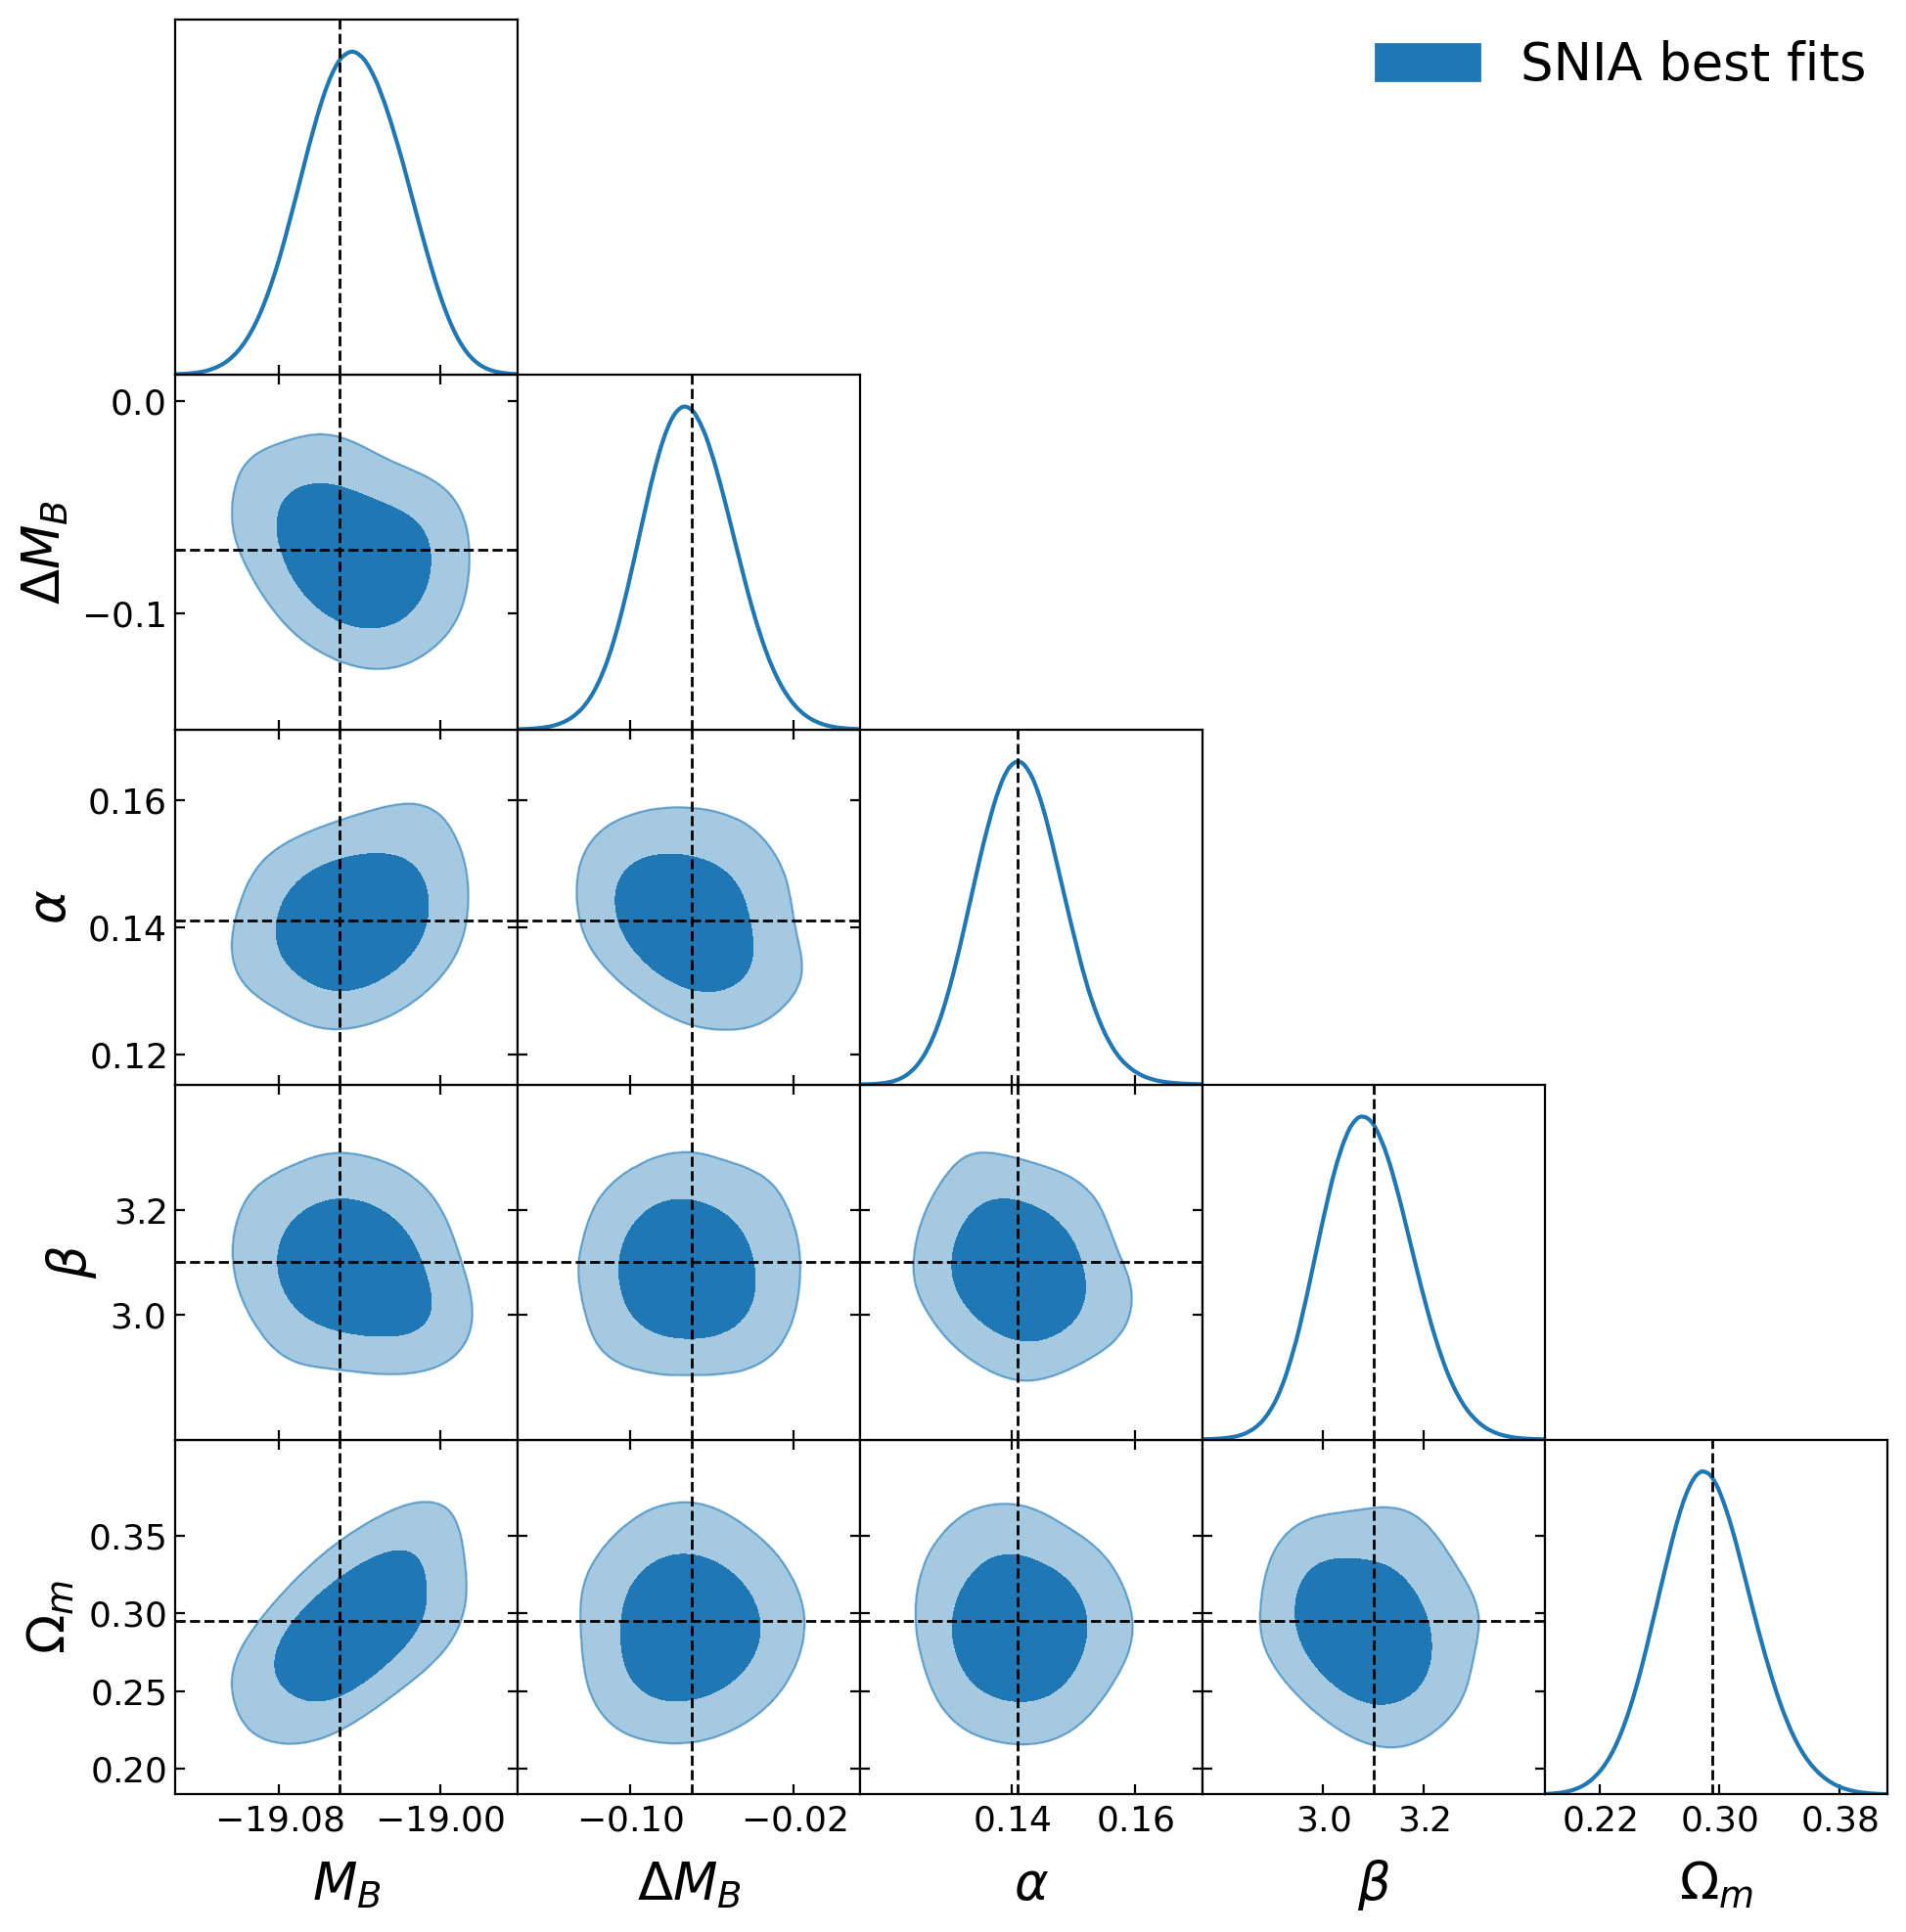

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.8  # Transparency for filled contours
g.settings.axis_marker_color = 'k'
g.settings.legend_fontsize =  22#16 #18
g.settings.axes_labelsize = 22  #22
g.settings.axes_fontsize = 16 #16
g.settings.axis_marker_lw = 1


g.triangle_plot([s], filled=[True, True, True, True],
               contour_colors=['tab:blue','tab:blue','tab:green'],figure_kwargs={"figsize": (15,15)},
                contour_lws = [1.5, 1.5, 1.5], contour_ls = ['-','-'],marker_args = ({'color':'k','lw' :  1}),
               markers = [-19.05,-0.070,0.141,3.101,0.295],
                legend_labels = ['SNIA best fits']
                ,legend_loc = 'upper right')

#plt.savefig('SN1A_fits')